# 2D Pad simulation sensitivity analysis

This Jupyter notebook contains the sensitivity analysis procedure used on the data Excel sheet which Huawei provided at the start of the collaboration. This analysis is done using methods provided by the [SALib](https://salib.readthedocs.io/en/latest/) library. Please refer to section 2.1.4 of the progress report for full context.

Let us first import the necessary packages and define some control parameters.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import GPy 
from SALib.sample import saltelli
from SALib.analyze import sobol

## Parameters for control
seed = 1988 # set a random seed to replicate results
testset_ratio = 0.25 # ratio of test set points from the dataset
##

Next, all necessary data for performing the sensitivity analysis are initialized. First, the full data set with modified parameters is introduced. Then, the features and target are identified and extracted. The data is then split to train the regressor (see next cell).

In [2]:
data_full = pd.read_csv('total_data_csv_parameter_modified.csv') # Load the full data
np.random.seed(seed)

feature_names = data_full.columns.values[1:8] # Names of features
X_data = data_full.iloc[:, 1:8 ].values # features data

target_name = data_full.columns.values[0] # Name of target
y_data = data_full.iloc[:, 0:1].values # target data
y_data = y_data.reshape(-1,1) # reshaped to have standard format for training

X_train, X_test, y_train, y_test = train_test_split(X_data,
                                    y_data, test_size=testset_ratio,
                                    random_state=seed)

X_train_scaled=X_train
X_test_scaled =X_test
X_data_scaled =X_data

Gaussian process regression is used to generate a surrogate model for the response surface. Here, heteroscedasticity is assumed, which in simple terms means that some variables will experience varying uncertainty across the surrogate.

In [3]:
kern = GPy.kern.RBF(input_dim=7, variance=1.0, lengthscale=10.0, ARD=False)

gpy_het_model = GPy.models.GPHeteroscedasticRegression(X_train_scaled,y_train,kern)
gpy_het_model.het_Gauss.variance = .005**2 # intial value (to be optimized)
gpy_het_model.optimize()

The next step consists of defining a dictionary which contains the problem to be analysed. This format will be used in the SALib commands.

In [4]:
problem = {
    'num_vars': len(feature_names),
    'names': feature_names,
    'bounds': [[0.8,1.2 ],
               [57.0,67.18],
               [0.0,1.0],
               [50.0,200.0],
               [30.0,38.0],
               [33.0,42.0],
               [2.0,3.0]]
}

The actual analysis step is executed with the Saltelli scheme, which makes use of Sobol sequence sampling to reduce the error rates of the calculations. The commands are as follows:

In [5]:
param_values = saltelli.sample(problem, 20000)
Y_pred, temp_trash= gpy_het_model.predict_noiseless(param_values)
Y_pred = Y_pred.reshape(-1,)

Si = sobol.analyze(problem, Y_pred, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
(h0-h1)/rd 0.000529 0.001120 0.003479 0.000094
h0+h1 0.174210 0.008921 0.218745 0.006552
h2 0.080805 0.005207 0.083862 0.002020
rs 0.143619 0.012744 0.388146 0.009522
w0 0.089099 0.010628 0.263953 0.007121
w1 0.143899 0.008170 0.190010 0.005739
rd 0.110529 0.006931 0.120614 0.003131

Parameter_1 Parameter_2 S2 S2_conf
(h0-h1)/rd h0+h1 -0.000186 0.001595
(h0-h1)/rd h2 -0.000216 0.001712
(h0-h1)/rd rs 0.002668 0.001722
(h0-h1)/rd w0 -0.000032 0.001738
(h0-h1)/rd w1 -0.000065 0.001738
(h0-h1)/rd rd 0.000050 0.001628
h0+h1 h2 -0.002754 0.012154
h0+h1 rs 0.031255 0.014429
h0+h1 w0 0.002173 0.012628
h0+h1 w1 0.003451 0.012017
h0+h1 rd -0.002158 0.013007
h2 rs 0.003103 0.008336
h2 w0 -0.000347 0.007373
h2 w1 0.000109 0.008508
h2 rd -0.000135 0.007743
rs w0 0.157791 0.017851
rs w1 0.030539 0.016080
rs rd 0.006266 0.015931
w0 w1 0.006477 0.015345
w0 rd -0.002198 0.015217
w1 rd 0.002721 0.010793


Once the sensitivity analysis has been finished, the final task to perform is to generate the visualizations, and display the heteroscedastic GPR surrogate model. 

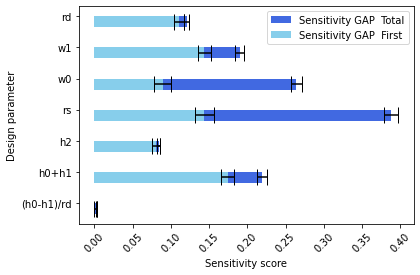


Name : gp
Objective : -344.3947766057223
Number of Parameters : 152
Number of Optimization Parameters : 152
Updates : True
Parameters:
  gp.                 |               value  |  constraints  |  priors
  rbf.variance        |  0.5437370998651334  |      +ve      |        
  rbf.lengthscale     |   40.12410468535615  |      +ve      |        
  het_Gauss.variance  |            (150, 1)  |      +ve      |        


In [6]:
fig1 = plt.figure()

x_pos = np.arange(len(feature_names))
width = 0.35
plt.barh(x_pos,Si['ST'],width, color='royalblue', xerr=Si['ST_conf'], label='Sensitivity GAP  Total', capsize=8)
plt.barh(problem['names'],Si['S1'],width, color='skyblue', xerr=Si['S1_conf'], label='Sensitivity GAP  First',capsize=8)

plt.xticks(rotation=45)
#
plt.xlabel('Sensitivity score')
plt.ylabel('Design parameter')

plt.yticks(x_pos + width / 2, feature_names)
plt.legend(loc='best')
plt.show()

print(gpy_het_model)